In [1]:
%load_ext autoreload

In [2]:
#coding=utf-8
%autoreload

import numpy as np
import os
import csv
from collections import Counter
import multiprocessing
from multiprocessing import Pool
import re
import pickle
import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gc
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import json
import active_search_utilities
import preprocessing_utilities
from scipy.stats import pearsonr

In [3]:
import global_variables

In [4]:
global_variables.init()

In [5]:
all_domains = ['kdd', 'kdd_papers', 'comp', 'fictions', 'acl-both']#, 'acl', 'acl-senior']

In [10]:
#domain = 'kdd'
domain = 'kdd_papers'
#domain = 'comp'
#domain = 'fictions'
#domain = 'acl'
#domain = 'acl-senior'
#domain = 'acl-both'

In [11]:
prefix = '..'

In [12]:
Q = json.load(open(prefix + '/' + domain + '-Q.json', 'r'))
if domain == 'fictions':
    for q in range(len(Q)):
        Q[q] = (list(set(Q[q][0])&sub_V), Q[q][1], Q[q][2])

In [13]:
preprocessed_data = json.load(open(prefix + '/' + domain + '_preprocessed_data.json', 'r'))
sub_V = set(preprocessed_data['sub_V'])
sub_E = set([tuple(x) for x in preprocessed_data['sub_E']])
sub_adj_list = preprocessed_data['sub_adj_list']
global_variables.vertex_to_code = preprocessed_data['vertex_to_code']
global_variables.embedding = np.array(preprocessed_data['embedding'])
global_variables.code_to_vertex = {v:k for k, v in global_variables.vertex_to_code.items()}
global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
global_variables.V_sims = np.load(prefix + '/' + domain + '_V_sims.npy')

In [15]:
# for ACL dataset (swapped lfs vs hfs in filenames isn't a typo!!! - just a current stub)
if domain == 'acl':
    global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_lfs.json', 'r'))
    global_variables.all_lfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
elif domain == 'acl-senior' or domain == 'acl-both':
    global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
    global_variables.all_lfs = json.load(open(prefix + '/' + domain + '_lfs.json', 'r'))

In [16]:
global_variables.all_lfs = [np.array(x) for x in global_variables.all_hfs]

In [17]:
Lambda = 100
lambda_low = 0 # special case for counting only high fidelity steps whereas low fidelities are queried *param* times per h.f.-step
lambda_high = 1.0
INITIAL_SEED_SET_SIZES = [5]

In [18]:
do_randomstart = False
if do_randomstart:
    random_or_intended_start = 'randomstart'
else:
    random_or_intended_start = 'intendedstart'

In [19]:
# only for INITIAL_SEED_SET_SIZE = 5
if domain == 'kdd':
    prior_random_for_all_tests = ['7BF1E508', '79AF60E7', '7E686170', '7F51C438', '1DEC6958']
elif domain == 'kdd_papers':
    prior_random_for_all_tests = ['60DC76D2', '80FF7C7F', '7E8F6385', '7752D599', '80F6983C']
elif domain == 'comp':
    prior_random_for_all_tests = ['81537778888748', '55497452495348', '77805587808648', '78878788805048', '8190507248']
elif domain == 'fictions':
    prior_random_for_all_tests = ['77667856756748', '83767053497248', '87534966486748', '75805252896648', '787650844948']
elif domain == 'acl':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']
elif domain == 'acl-senior':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']
elif domain == 'acl-both':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']

In [22]:
test_params_set = []
for q in range(0, len(Q)):
    for INITIAL_SEED_SET_SIZE in INITIAL_SEED_SET_SIZES:
        test_params_set.append((q, INITIAL_SEED_SET_SIZE))

In [23]:
def test_algorithm(algorithm, alg_params = {}, prefix = ''):
    for p in test_params_set:
        q, INITIAL_SEED_SET_SIZE = p

        print('======================================================')
        print('START TEST:', q, INITIAL_SEED_SET_SIZE)

        interest_nodes = Q[q][0]
        interest_codes = [global_variables.vertex_to_code[v] for v in interest_nodes]
        seed_set_high = []
        if do_randomstart:
            rnd = prior_random_for_all_tests
        else:
            #rnd = #Q[q][0][:INITIAL_SEED_SET_SIZE]
            rnd = prior_random_for_all_tests
        for i in range(INITIAL_SEED_SET_SIZE):   
            seed_set_high.append((global_variables.vertex_to_code[rnd[i]], 
                                  active_search_utilities.high_fidelity_experimental(q, global_variables.vertex_to_code[rnd[i]])\
                                  + np.random.randn()*0.00001))
        seed_set_low = [(c, active_search_utilities.low_fidelity_experimental(q, c, seed_set_high)) for c, _ in seed_set_high]
        if algorithm == 'labelprop':
            logger = active_search_utilities.run_test_labelprop(Q, q, Lambda, lambda_high, seed_set_high,
                                                               alg_params['n_neighbours'])
        elif algorithm == 'gplapl':
            logger = active_search_utilities.run_test_gplapl(Q, q, Lambda, lambda_high, seed_set_high, 
                                                             alg_params['alpha'])
        elif algorithm == 'mfgplapl':
            logger = active_search_utilities.run_test_mfgplapl(Q, q, Lambda, lambda_high, lambda_low, seed_set_high, seed_set_low, 
                                                               alg_params['alpha_high'], alg_params['alpha_low'], alg_params['low_per_high'])
        print(logger['params']['_q'])
        if algorithm == 'labelprop':
            suffix = '_' + str(global_variables.embedding.shape[1]) + 'D'
        elif algorithm == 'mfgplapl':
            suffix = '_' + str(alg_params['low_per_high'])
        else:
            suffix = ''
        pickle.dump(logger, open('../loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                 + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix + '.pkl', 'wb'))


In [24]:
from tqdm import tqdm

In [25]:
pre_sorted_all = np.argsort(global_variables.V_sims, axis = 1)[:, ::-1]

In [26]:
def make_low_fidelity_correlated(hfs, k = 5, seed_part = 0.1, blend = 0.5, skip = 1):
    if seed_part == 1.0:
        tmp_sub = np.arange(len(hfs))
    else:
        tmp_sub = np.random.choice(len(hfs), int(seed_part*len(hfs)), replace = False)
    
    smooth = np.mean(hfs)
    #smooth = 0
    sims_v_to_seed_all = global_variables.V_sims[:, tmp_sub]
    if seed_part == 1.0:
        sub_sims_all = np.array(pre_sorted_all)[:, skip:k]
    else:
        sub_sims_all = np.argsort(sims_v_to_seed_all, axis = 1)[:, ::-1][:, skip:k]
    hfs = np.array(hfs)
    n = len(sub_sims_all)
    lfs = np.zeros(n)
    x = (np.ones((k - skip, n)) * np.arange(n)).T.astype(int)
    sub_sims_v_to_seed_all = sims_v_to_seed_all[x, sub_sims_all]
    hfs_tmp_sub = hfs[tmp_sub]
    sub_hfs_tmp_sub = hfs_tmp_sub[sub_sims_all]
    sum_sub_sims_hfs_product = np.sum(sub_sims_v_to_seed_all * sub_hfs_tmp_sub, axis = 1)
    sum_sub_sims_v_to_seed_all = np.sum(sub_sims_v_to_seed_all, axis = 1)
    lfs_base_all = (smooth + sum_sub_sims_hfs_product) / (1.0 + sum_sub_sims_v_to_seed_all)
    lfs = (lfs_base_all * blend + (1 - blend) * hfs)
    return lfs    

def fit_worker(p, hfs):
    lfs = make_low_fidelity_correlated(hfs, k = p[0], seed_part = 1.0, blend = p[1], skip = p[2])
    return lfs

def bootstrap_to_fit_correltaion(hfs, target_corr):
    params = []
    for k in [5, 10, 25, 50]:
        for blend in [0.75, 0.9, 1.0]:
            for skip in [1, 3, 5, 10, 20]:
                if skip < k:
                    params.append((k, blend, skip))
                
    #res = Parallel(n_jobs=8, verbose=0) (delayed(fit_worker)(p, hfs) for p in params)
    res = [fit_worker(p, hfs) for p in params]
    best_delta = np.inf
    best_i = -1
    for i in range(len(res)):
        if np.abs(pearsonr(res[i], hfs)[0] - target_corr) < best_delta:
            best_delta = np.abs(pearsonr(res[i], hfs)[0] - target_corr)
            best_i = i
    return res[best_i], params[best_i]

In [ ]:
hfs_all = [np.array(global_variables.all_hfs[q]) for q in range(len(global_variables.all_hfs))]
scale_rate = 1000
for corr_level in [0.5, 0.75, 0.9, 1.0]:
    global_variables.all_lfs = []
    corrs = []
    corrs_rough = []
    for q in tqdm(range(len(Q))):
        #lfs, lp = bootstrap_to_fit_correltaion(hfs_all[q], corr_level)
        
        global_variables.all_hfs[q] = np.round(np.array(hfs_all[q])*scale_rate)/float(scale_rate)
        lfs, lp = bootstrap_to_fit_correltaion(global_variables.all_hfs[q], corr_level)
        global_variables.all_lfs.append(lfs)
        corrs.append(pearsonr(lfs, hfs_all[q])[0])
        corrs_rough.append(pearsonr(lfs, global_variables.all_hfs[q])[0])
    plt.figure(figsize = (4, 4))
    plt.axis([0, 1, 0, 1])
    plt.title(corr_level)
    plt.scatter(corrs, corrs_rough, s= 1)
    

In [ ]:
for corr_level in [0.5, 0.75, 0.9, 1.0]:
    global_variables.all_lfs = []
    corrs = []
    for q in tqdm(range(len(Q))):
        if corr_level == 1.0:
            lfs = np.array(global_variables.all_hfs[q])
        else:
            lfs, lp = bootstrap_to_fit_correltaion(global_variables.all_hfs[q], corr_level)
        
        global_variables.all_lfs.append(lfs)
        corrs.append(pearsonr(lfs, global_variables.all_hfs[q])[0])
    start_time = time.time()
    for lph in [1, 3, 5, 10]:
        test_algorithm('mfgplapl', {'alpha_high':0.001, 'alpha_low':0.01, 'low_per_high':lph}, prefix='corr_' + str(corr_level) + '_')
    print(corr_level, lph, time.time() - start_time)
    #test_algorithm('mfgplapl', {'alpha_high':0.001, 'alpha_low':0.01, 'low_per_high':10}, prefix='corr_' + corr_level + '_')
    #test_algorithm('mfgplapl', {'alpha_high':0.001, 'alpha_low':0.01, 'low_per_high':10}, prefix='corr_' + corr_level + '_')

In [ ]:
test_algorithm('gplapl', {'alpha':0.01})

In [38]:
old_loggers_prefix = '..'

In [ ]:
lph_stats_all = []


clrs = ['b', 'g', 'r', 'yellow', 'cyan', 'magenta', 'black']   
for LPH in [1, 3, 5, 10]:
    print('')
    lph_stats = {'gplapl_1.0':[], 'mfgplapl_1.0':[], 'mfgplapl_0.9':[], 'mfgplapl_0.75':[], 'mfgplapl_0.5':[]}
    for top_k in [100 + 5 - 1]:
        #plt.figure(figsize = (5, 3))
        plt.title('test all' + '\n' + 'top_k = ' + str(top_k))
        for q in range(0,len(Q)):

            print('!', end = '')
            oracle = sorted(global_variables.all_hfs[q], reverse=True)
            cur_stat = []
            random_or_intended_start = 'intendedstart'
            logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + 'gplapl' + '_' + str(q) + '_' \
                                     + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + '.pkl', 'rb'))
            #, encoding='latin1')

            for i, it in enumerate(logger['iter_data']):
                expected_val = 0
                RUN = 50
                for rand_gen in range(RUN):
                    random_pick = np.random.choice(len(global_variables.all_hfs[q]), 
                                                   len(logger['iter_data'][i]['seed_set_high']), 
                                                   replace = False)
                    utilities = [global_variables.all_hfs[q][x] for x in random_pick]
                    expected_val += np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1])
                cur_stat.append(expected_val/RUN)
            rand_stat = np.array(cur_stat)
            clr_id = 0

            #add algs:
            for algorithm in ['gplapl', 'mfgplapl']:
                for corr in ['1.0', '0.9', '0.75', '0.5']:



                    if algorithm == 'mfgplapl':
                        prefix = 'corr_' + corr + '_'
                        low_per_high = LPH
                        random_or_intended_start = 'randomstart'
                        suffix = '_' + str(low_per_high)
                    elif algorithm == 'gplapl':
                        prefix = ''
                        suffix = ''
                        random_or_intended_start = 'intendedstart'
                        low_per_high = 0
                        if corr != '1.0':
                            continue
                    else:
                        prefix = ''
                        suffix = ''
                        low_per_high = 0
                        if corr != '1.0':
                            continue
                    logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                         + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix +'.pkl', 'rb'))
                    #, encoding='latin1')

                    cur_stat = []
                    for i, it in enumerate(logger['iter_data']):
                        if logger['iter_data'][i]['iteration'] % (low_per_high + 1) == 0:
                            #utilities = [x[1] for x in logger['iter_data'][i]['seed_set_high']]
                            utilities = [global_variables.all_hfs[q][x[0]] for x in logger['iter_data'][i]['seed_set_high']]
                            cur_stat.append(np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1]))

                    lph_stats[algorithm + '_' + corr].append(np.divide(cur_stat, rand_stat))
                    clr_id += 1

    lph_stats_all.append(lph_stats)


In [48]:
keys = ['gplapl_1.0', 'mfgplapl_1.0', 'mfgplapl_0.9', 'mfgplapl_0.75', 'mfgplapl_0.5']

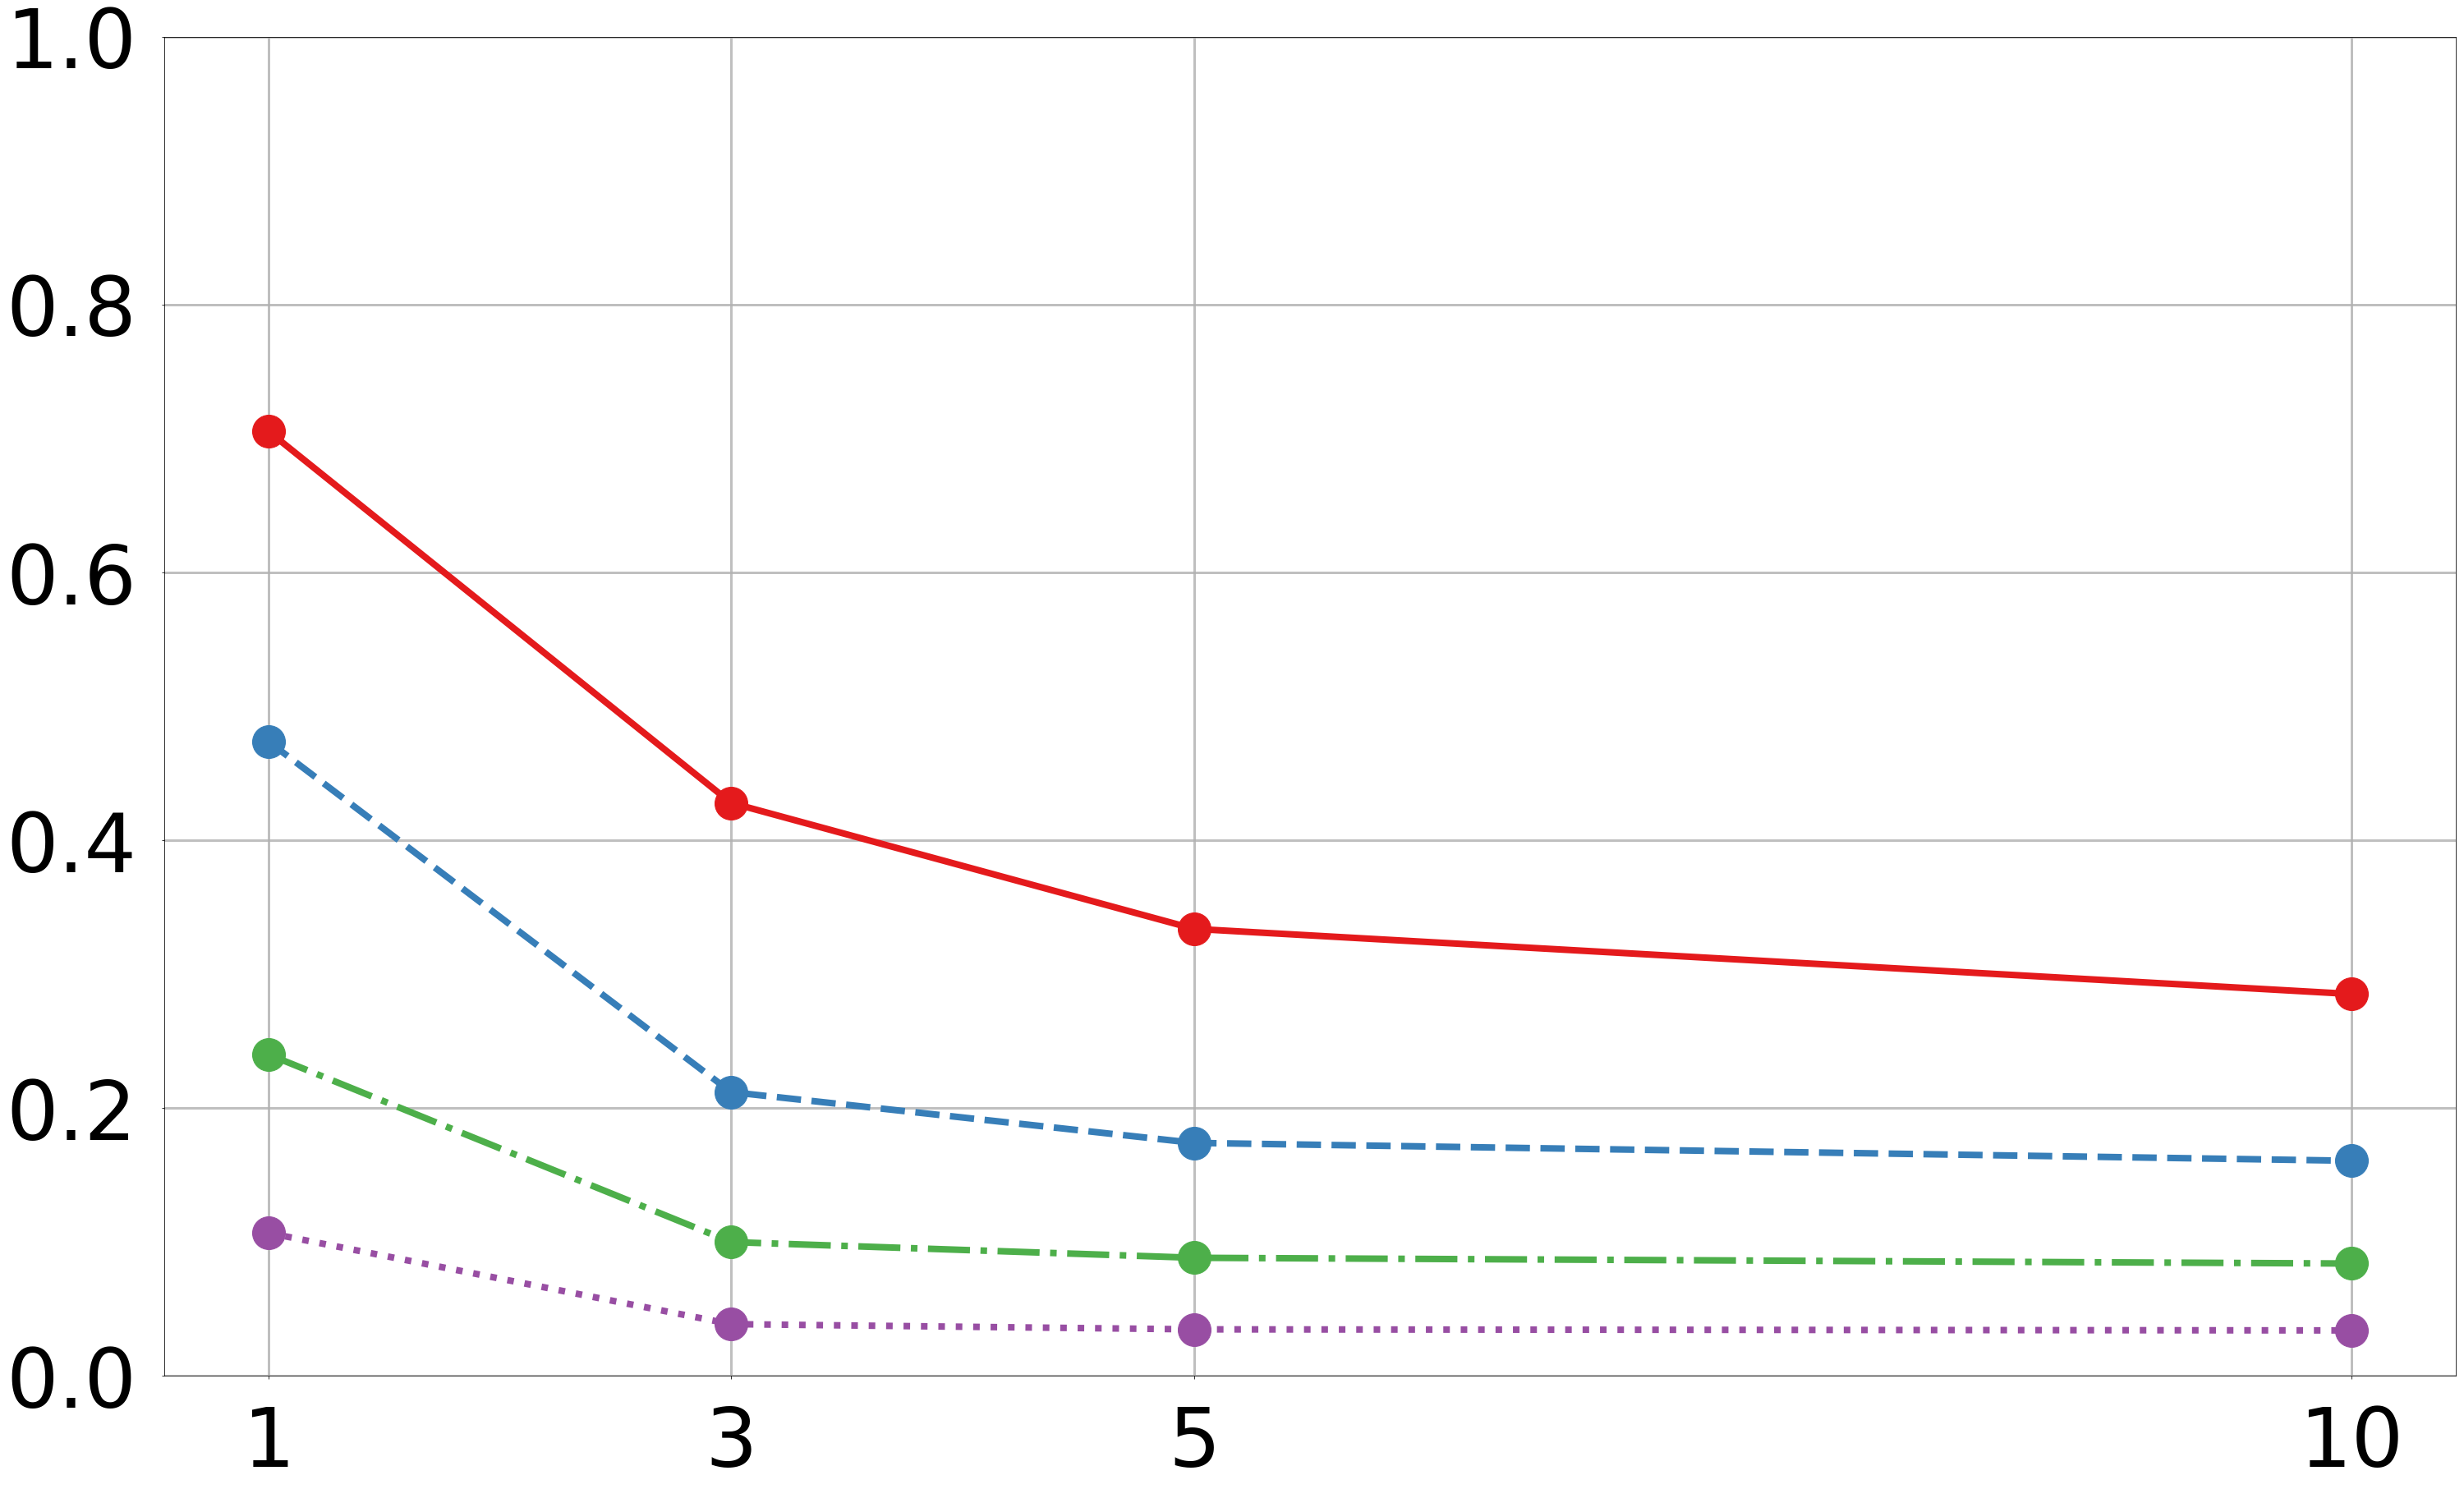

In [58]:
lphs = [1, 3, 5, 10]

pp = PdfPages('performance_'+domain+'_all_lph_restarting.pdf')
LW_MEAN = 8
LW_Q =4

algorithm = 'mfgplapl_1.0'
plt.figure(figsize=(50, 30))
linestyles = ['-', '--', '-.', ':']
for k, high_q in enumerate([10, 20, 40, 99]):
    regrs = [np.mean(lph_stats_all[i][algorithm], axis = 0)[high_q] for i in range(len(lphs))]
    plt.plot(lphs, regrs, marker = 'o', color = cm.Set1(k/9.), linestyle = linestyles[k], label = 'hq='+str(high_q),
            linewidth = LW_MEAN, markersize= 40)
    #regrs = [np.percentile(lph_stats_all[i][algorithm], 90, axis = 0)[high_q] for i in range(len(lphs))]
    #plt.plot(lphs, regrs, color = cm.Set1(k/9.), linewidth = 0.5, linestyle = '--')
    #regrs = [np.percentile(lph_stats_all[i][algorithm], 10, axis = 0)[high_q] for i in range(len(lphs))]
    #plt.plot(lphs, regrs, color = cm.Set1(k/9.), linewidth = 0.5, linestyle = '--')
plt.xticks(lphs);
plt.ylim([0, 1])
#plt.legend()
plt.tick_params(axis='both', which='major', labelsize=100)
plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  


plt.gca().tick_params(axis='x', pad=30)
plt.gca().tick_params(axis='y', pad=30)
pp.savefig()
pp.close()

In [50]:
clrs = ['g'] + [cm.Reds(0.7*(i/5.)+ 0.3) for i in range(5)][::-1]

In [56]:
linestyles = { 'mfgplapl_1.0':':', 'mfgplapl_0.9':'-.', 'mfgplapl_0.75':'--'}

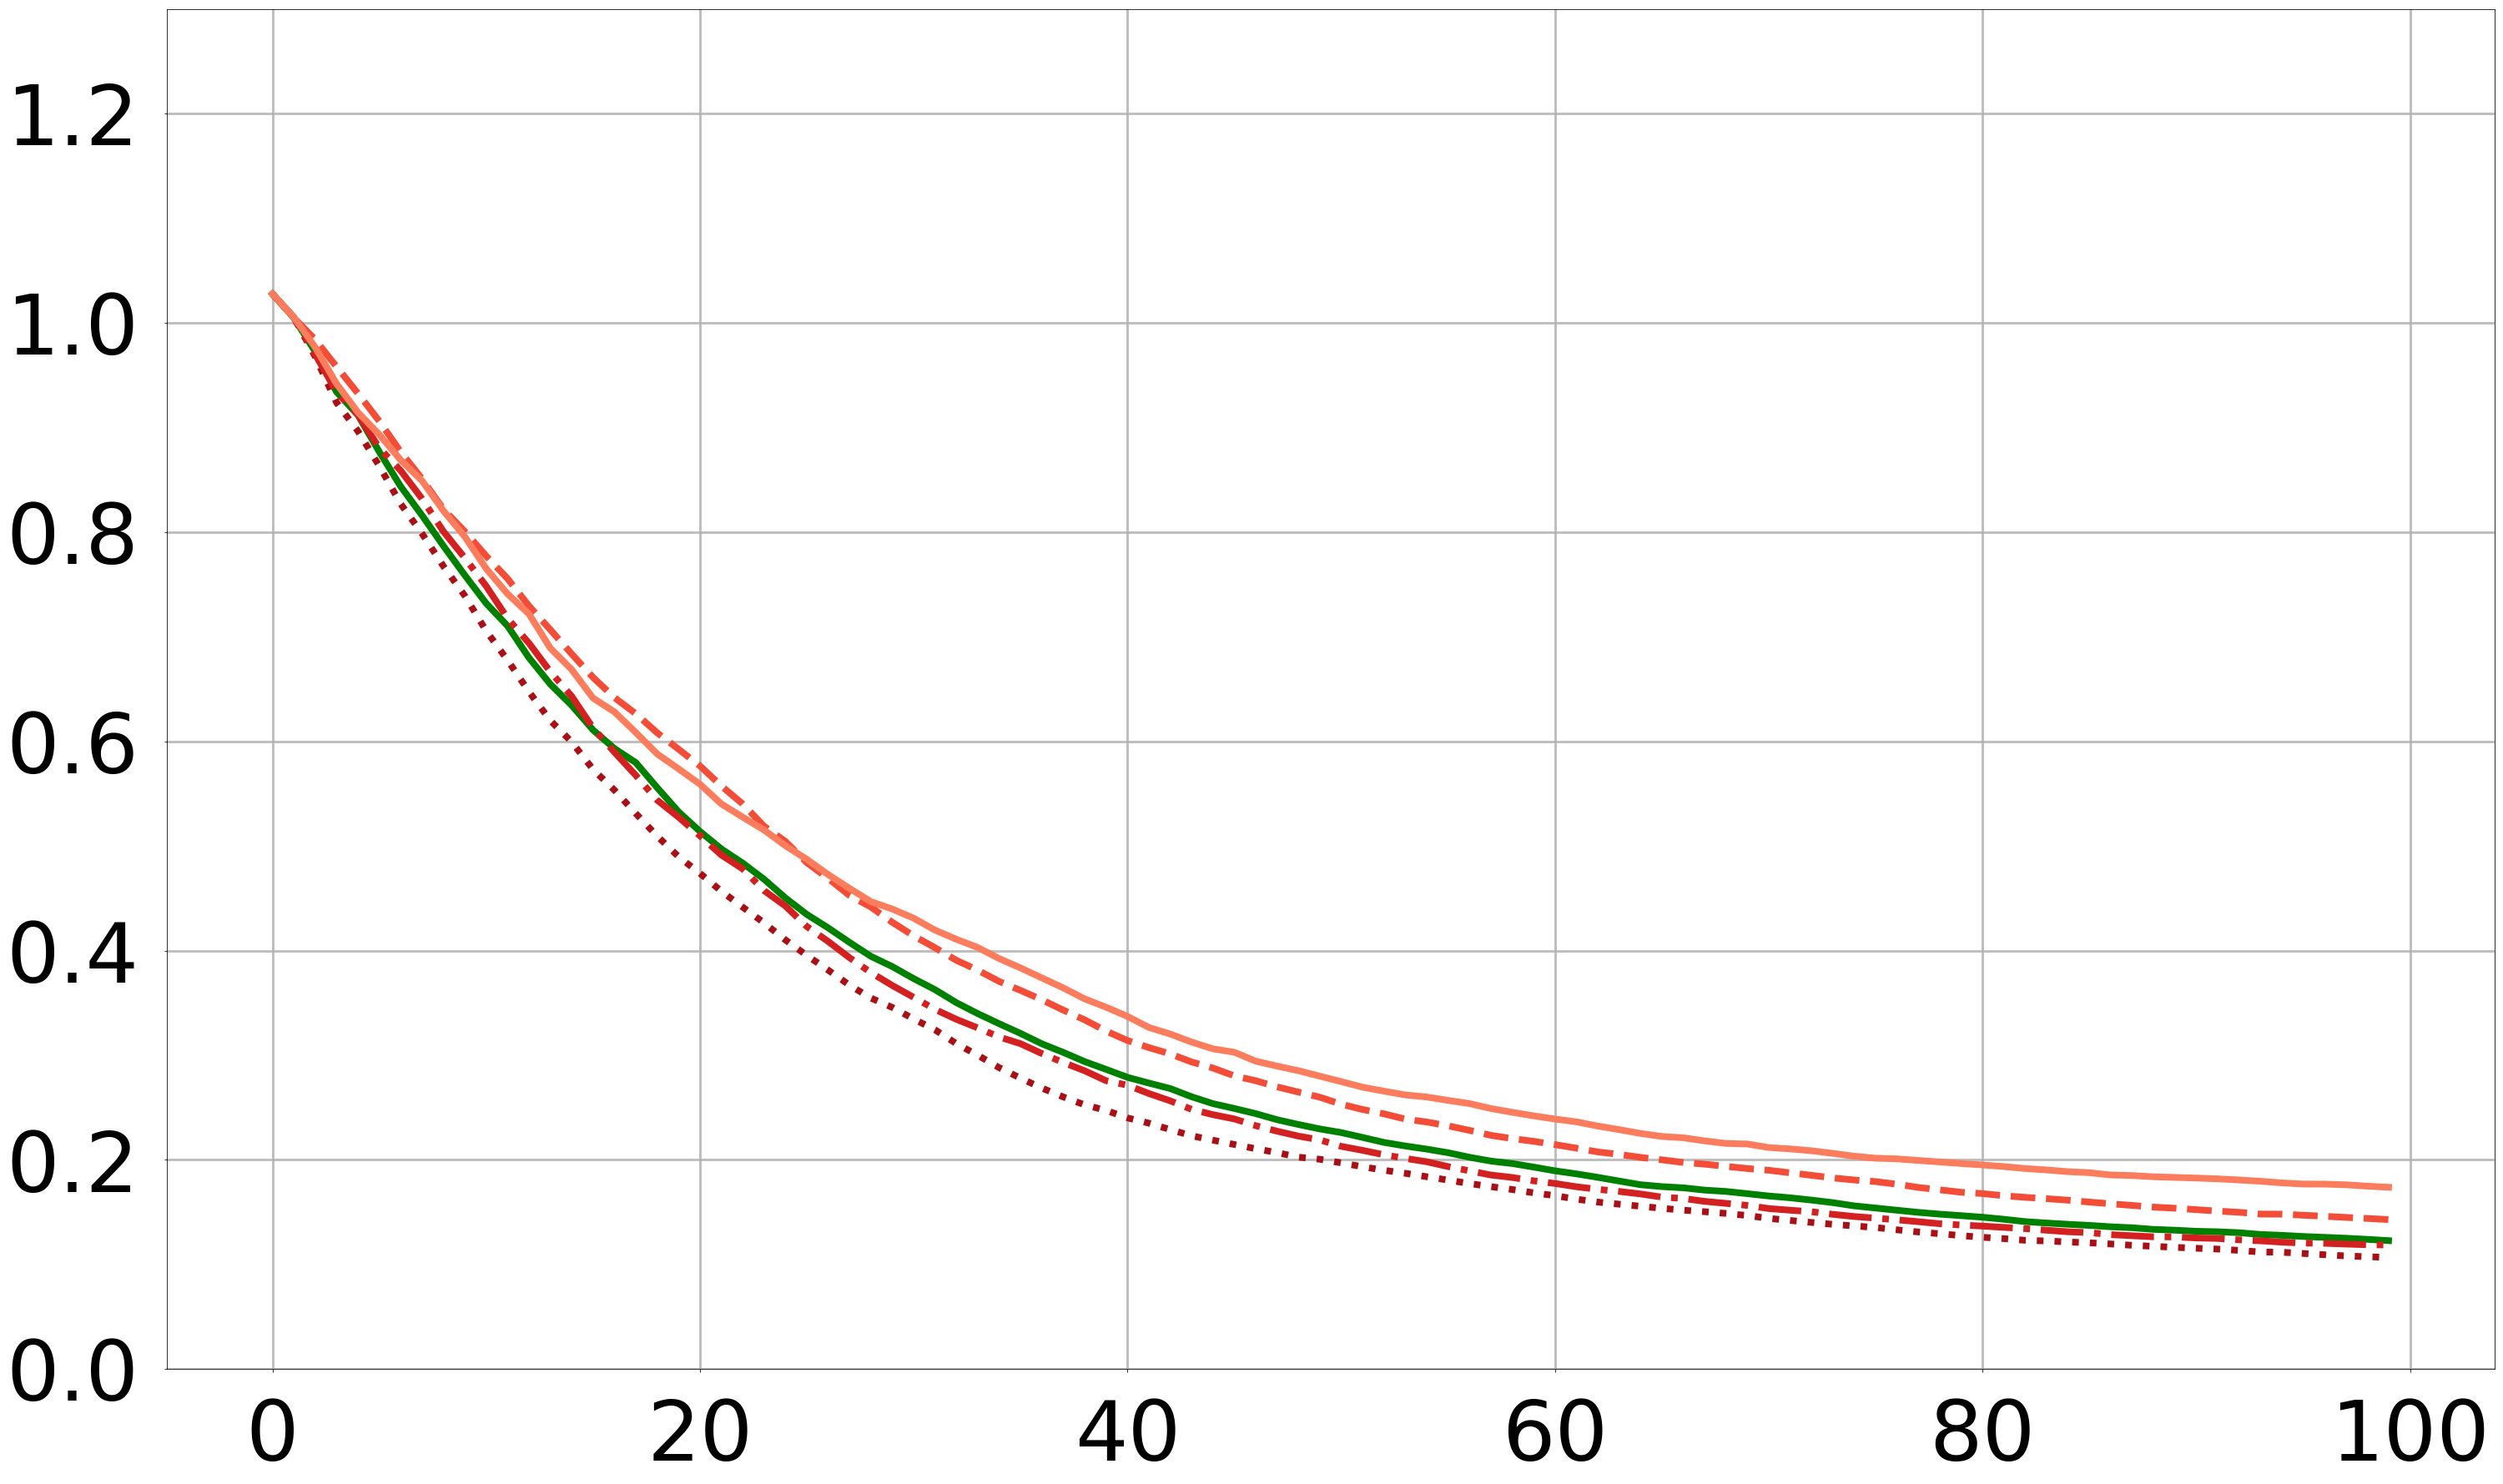

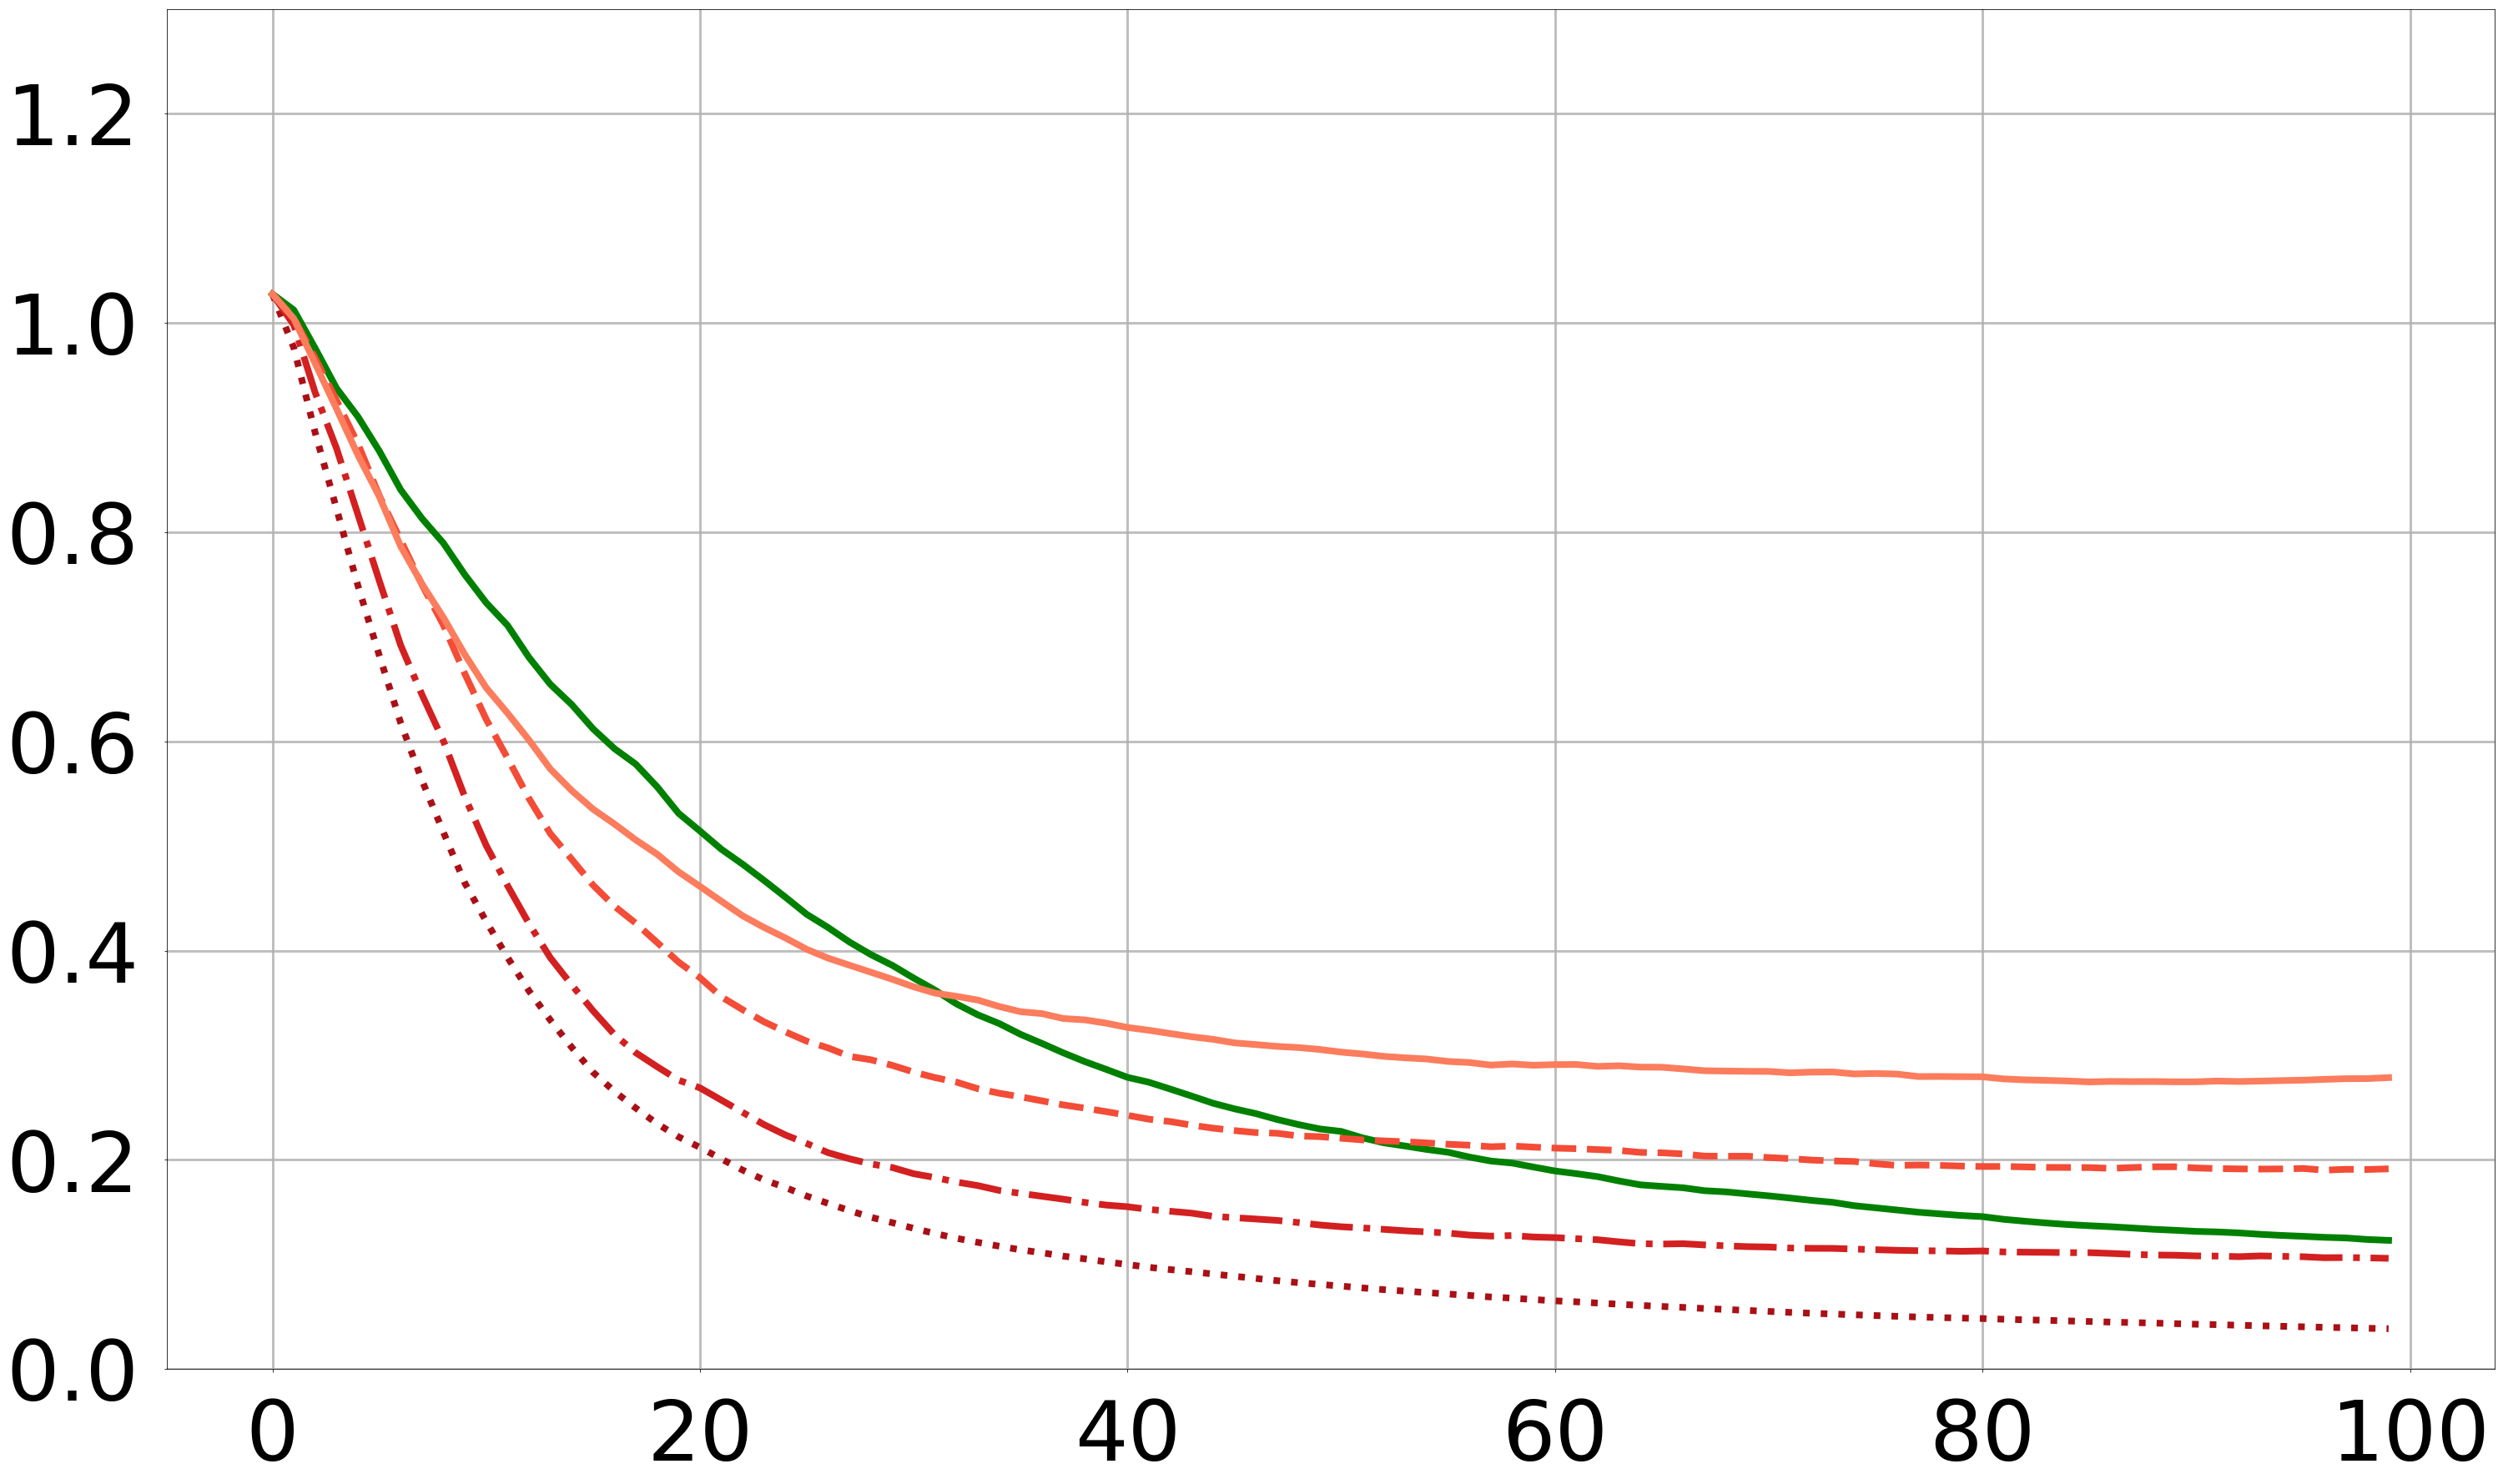

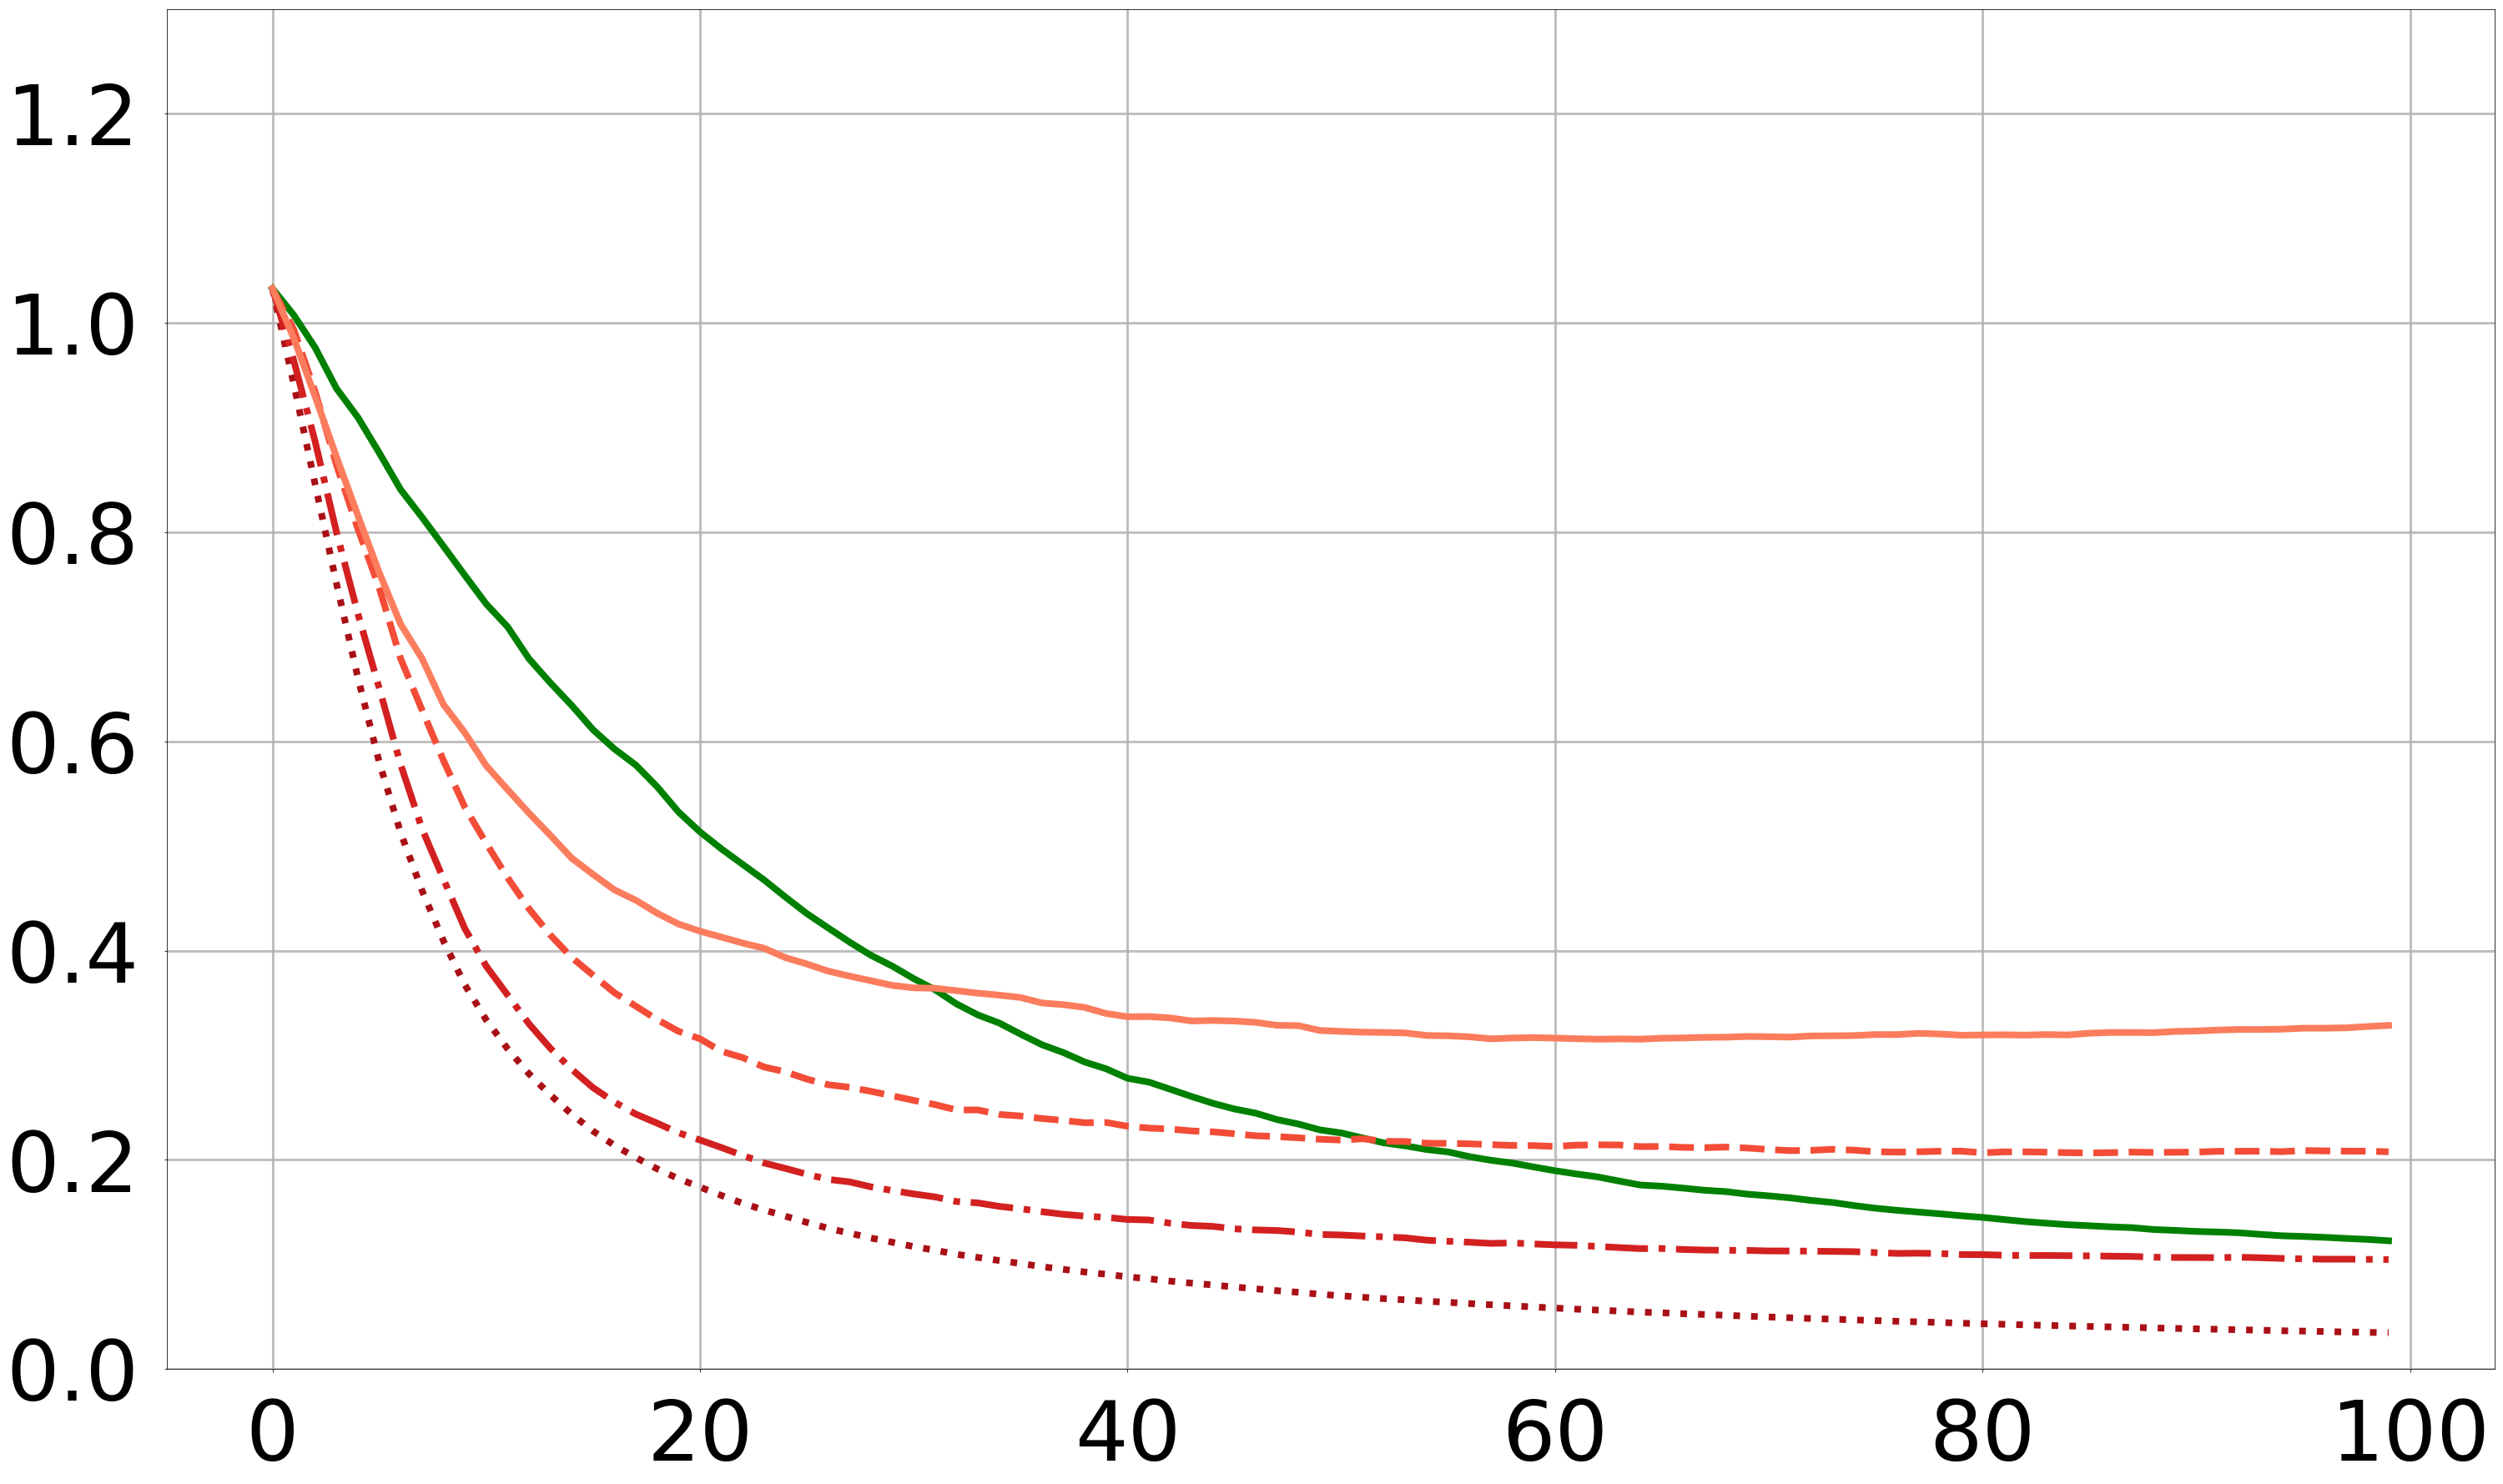

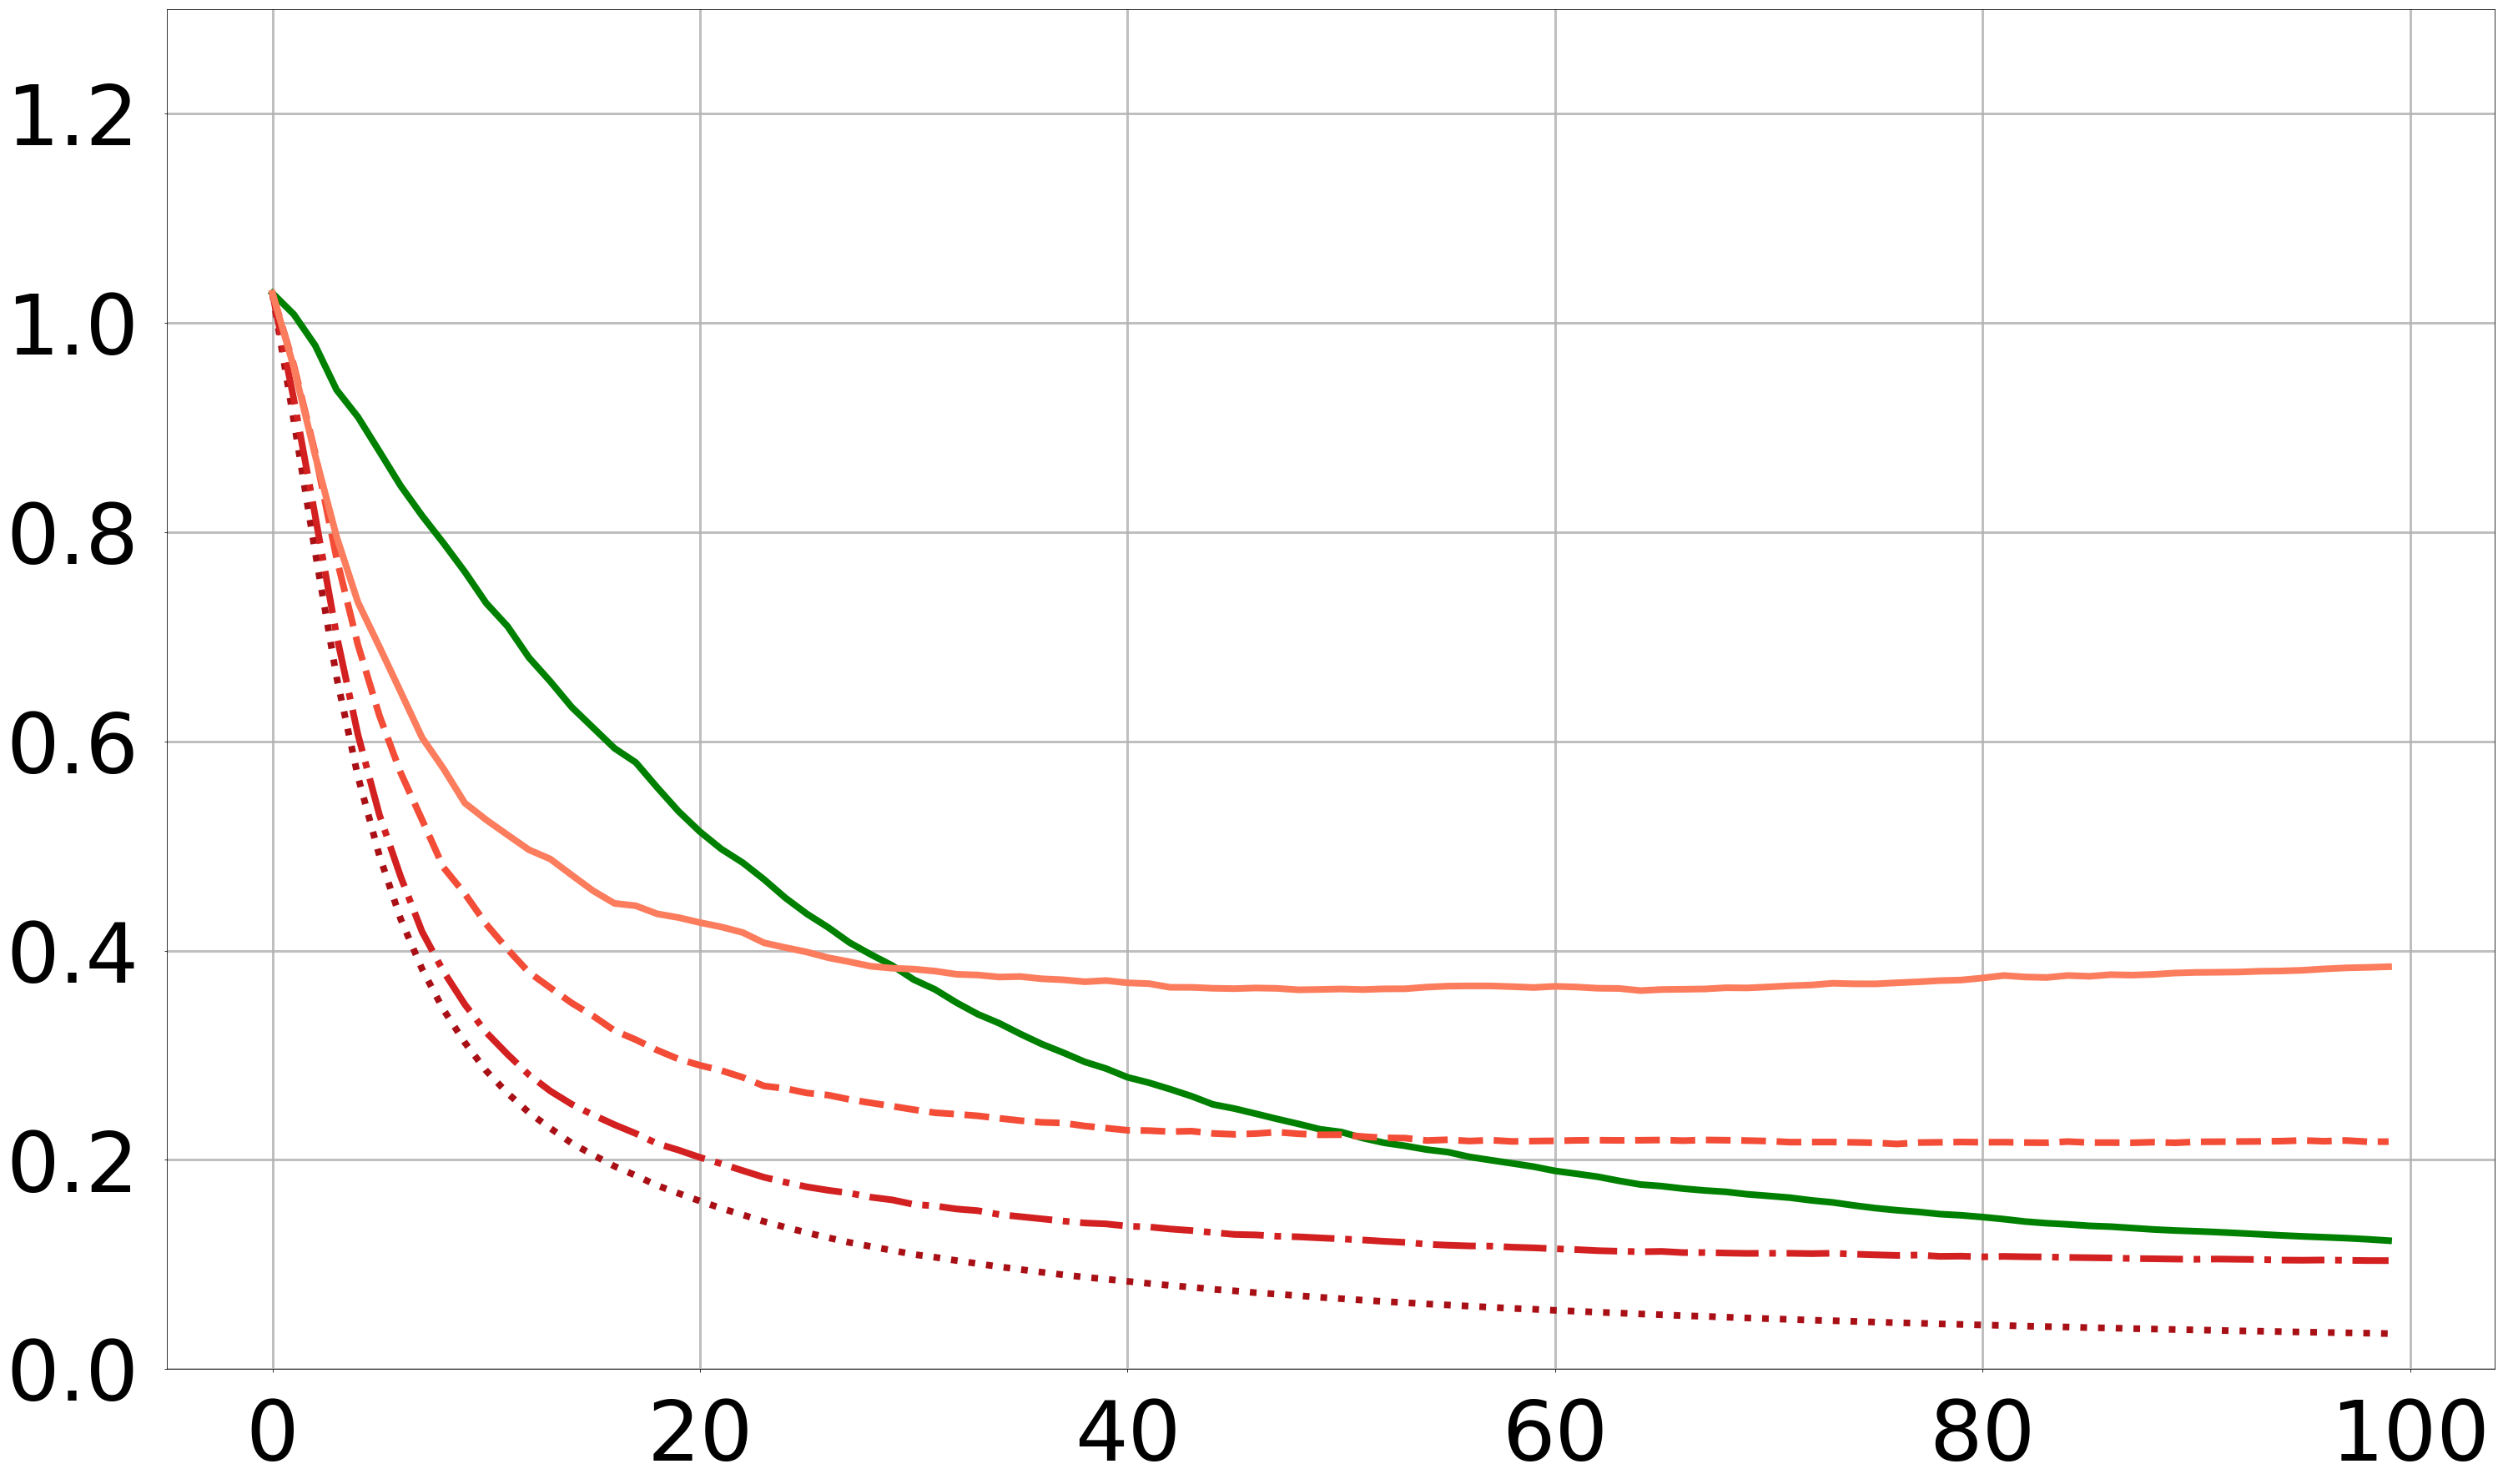

In [57]:
for i, LPH in enumerate(lphs):
    pp = PdfPages('performance_kdd_papers_lph_' + str(LPH) + '.pdf')

    clr_id = 0
    LW_MEAN = 8
    LW_Q =4
    curve_labels = ['gplapl']
    for corr in ['1.0', '0.9', '0.75', '0.5']:
        curve_labels.append('x:1 mfgplapl corr=' + corr)
    plt.figure(figsize = (50, 30))
    lph_stats = lph_stats_all[i]
    for algorithm in keys:


        plt.plot(np.mean(lph_stats[algorithm], axis = 0), color = clrs[clr_id], label = curve_labels[clr_id], 
                 linewidth = LW_MEAN, linestyle=linestyles.get(algorithm, '-'))
        clr_id += 1


    plt.tick_params(axis='both', which='major', labelsize=100)
    plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  
    plt.ylim([0, 1.3])

    plt.gca().tick_params(axis='x', pad=30)
    plt.gca().tick_params(axis='y', pad=30)
    pp.savefig()
    pp.close()

In [59]:
hfs_all = [np.array(x) for x in global_variables.all_hfs]

In [ ]:
for scale_rate in [1, 2, 4, 9]:
    for i in range(len(Q)):
        global_variables.all_hfs[i] = np.round(np.array(hfs_all[i])*scale_rate)/float(scale_rate)
    test_algorithm('gplapl', {'alpha':0.01}, 
                   prefix = 'rough_' + str(scale_rate + 1) + '_')
    for corr_level in [1.0, 0.9, 0.75, 0.5]:
        global_variables.all_lfs = []
        for q in tqdm(range(len(Q))):
            if corr_level == -1.0:
                lfs = -np.array(hfs_all[q])
            elif corr_level == 0.0:
                lfs = np.array(np.random.rand(len(hfs_all[q])))
                
            elif corr_level == 1.0:
                lfs = np.array(hfs_all[q])
            else:
                lfs, lp = bootstrap_to_fit_correltaion(hfs_all[q], corr_level)

            global_variables.all_lfs.append(lfs)

        test_algorithm('mfgplapl', {'alpha_high':0.001, 'alpha_low':0.01, 'low_per_high':5}, 
                   prefix = 'rough_' + str(scale_rate + 1) + '_corr_' + str(corr_level) + '_')

In [62]:
for i in range(len(Q)):
    global_variables.all_hfs[i] = np.array(hfs_all[i])
    

In [ ]:

clrs = ['b', 'g', 'r', 'yellow', 'cyan', 'magenta', 'black']   
LPH = 5
scale_rates = [1,2,4,9]
lph_stats = {alg + '_' + str(sr + 1):[] for alg in ['gplapl', 'mfgplapl'] for sr in scale_rates}
correlations = [1.0, 0.9, 0.75, 0.5]
corr = correlations[0]
#scale_rate = 9
for top_k in [100 + 5 - 1]:
    for sr in scale_rates:
        print('')
        #for i in range(len(Q)):
        #    global_variables.all_hfs[i] = np.round(np.array(hfs_all[i])*sr)/float(sr)
    
        for q in range(0,len(Q)):
        
            print('!', end = '')
            oracle = sorted(global_variables.all_hfs[q], reverse=True)
            cur_stat = []
            logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + 'gplapl' + '_' + str(q) + '_' \
                                     + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + '.pkl', 'rb'),
                                encoding='latin1')

            for i, it in enumerate(logger['iter_data']):
                expected_val = 0
                RUN = 50
                for rand_gen in range(RUN):
                    random_pick = np.random.choice(len(global_variables.all_hfs[q]), 
                                                   len(logger['iter_data'][i]['seed_set_high']), 
                                                   replace = False)
                    utilities = [global_variables.all_hfs[q][x] for x in random_pick]
                    expected_val += np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1])
                cur_stat.append(expected_val/RUN)
            rand_stat = np.array(cur_stat)
            for algorithm in ['gplapl', 'mfgplapl']:
                if algorithm == 'mfgplapl':
                    prefix = 'rough_' + str(sr + 1) + '_corr_' + str(corr) + '_'
                    low_per_high = LPH
                    suffix = '_' + str(low_per_high)
                else:
                    prefix = 'rough_' + str(sr + 1) + '_'
                    suffix = ''
                    low_per_high = 0
                    #if corr != '1.0':
                    #    continue
                logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                     + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix +'.pkl', 'rb'),
                                    encoding='latin1')

                cur_stat = []
                for i, it in enumerate(logger['iter_data']):
                    if logger['iter_data'][i]['iteration'] % (low_per_high + 1) == 0:
                        utilities = [global_variables.all_hfs[q][x[0]] for x in logger['iter_data'][i]['seed_set_high']]
                        cur_stat.append(np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1]))

                lph_stats[algorithm + '_' + str(sr + 1)].append(np.divide(cur_stat, rand_stat))
                    #clr_id += 1
            
       
           
   

In [92]:
clrs = [cm.Greens(0.7*(i/4.)+ 0.3) for i in range(len(scale_rates))]+ [cm.Reds(0.7*(i/4.)+ 0.3) for i in range(len(scale_rates))]


In [93]:
keys = []
for algorithm in ['gplapl', 'mfgplapl']:
    for sr in scale_rates:
        keys.append(algorithm + '_' + str(sr + 1))

In [97]:
linestyles = {
 'gplapl_2':'-',
 'gplapl_3':'--',
 'gplapl_5':'-.',
 'gplapl_10':':',
 'mfgplapl_2':'-',
 'mfgplapl_3':'--',
 'mfgplapl_5':'-.',
 'mfgplapl_10':':'}

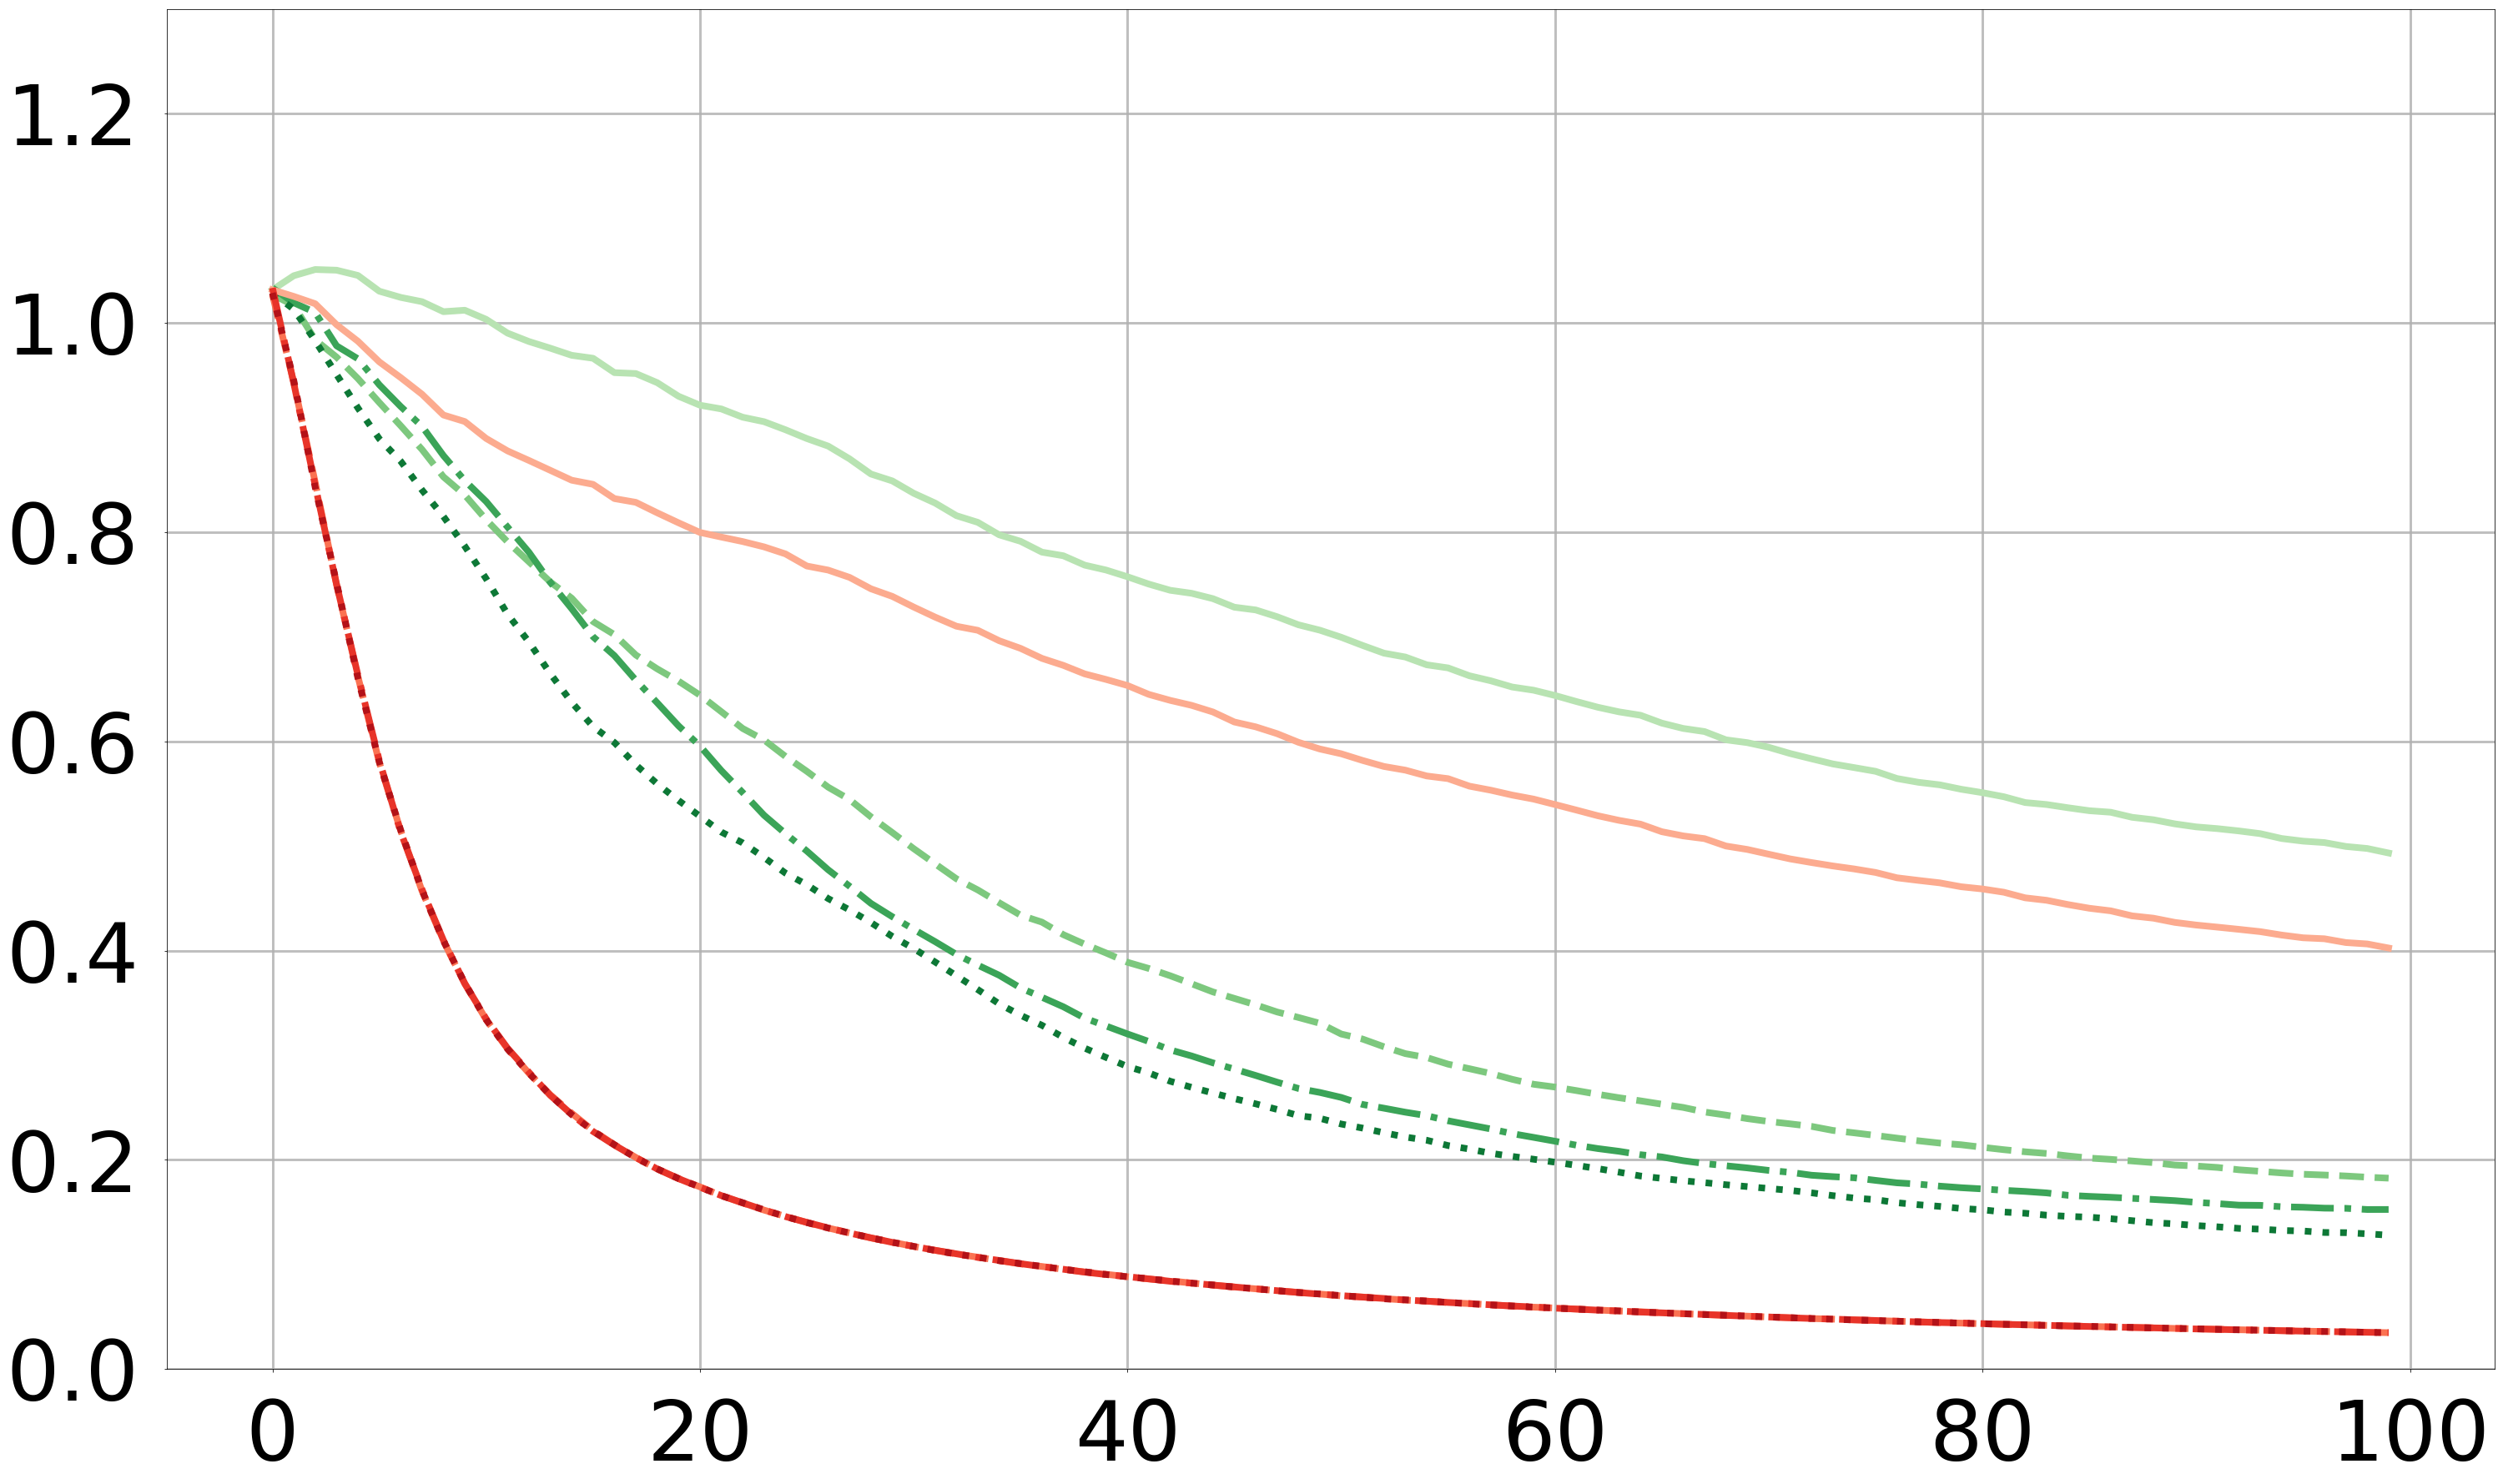

In [98]:

pp = PdfPages('performance_kdd_papers_rough_corr_'+str(corr)+'.pdf')

clr_id = 0
LW_MEAN = 8
LW_Q =4
plt.figure(figsize = (50, 30))

for algorithm in keys:
    
    plt.plot(np.mean(lph_stats[algorithm], axis = 0), color = clrs[clr_id], 
             linewidth = LW_MEAN, linestyle=linestyles[algorithm])
    clr_id += 1
#plt.legend(fontsize = 100)

plt.tick_params(axis='both', which='major', labelsize=100)
plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  
plt.ylim([0, 1.3])

plt.gca().tick_params(axis='x', pad=30)
plt.gca().tick_params(axis='y', pad=30)
pp.savefig()
pp.close()